# Colour by Numbers

In this notebook, I investigate the number of elements in each cell of the following Venn diagram.

![image](https://cloud.githubusercontent.com/assets/2681312/15461335/8f50f506-20fd-11e6-82f2-cb3c8e8fd1d7.png)

That is:

- How many galaxies are there in the SWIRE catalogue $\cap$ the RGZ&ndash;ATLAS dataset?
- How many galaxies are *isolated*, i.e., are the only galaxy in their $0.8'$ neighbourhood?
- How many galaxies have active galactic nuclei (AGN)?
- How many galaxies are isolated *and* have AGN?

The true number of AGN is unknown.

In [1]:
import sys

sys.path.insert(1, '..')
import crowdastro.data

## How many objects are in SWIRE $\cap$ RGZ&ndash;ATLAS?

I don't have a proper dump of the SWIRE catalogue; I only have a request cache. I'll have to iterate over RGZ&ndash;ATLAS subjects, grab the names and positions of each object, then remove duplicate objects. For bonus points, getting the positions lets me use Alasdair's honours project to generate a heatmap of galaxies in RGZ&ndash;ATLAS.

(I should really remove the requests_cache dependency at some point.)

### Fetching unique objects

In [2]:
import io

import astropy.io.votable
import requests
import requests_cache

requests_cache.install_cache(cache_name='gator_cache', backend='sqlite', expire_after=None)

In [3]:
def fetch(subject):
    if subject['metadata']['source'].startswith('C'):
        # CDFS
        catalog = 'chandra_cat_f05'
    else:
        # ELAIS-S1
        catalog = 'elaiss1_cat_f05'
    
    query = {
        'catalog': catalog,
        'spatial': 'box',
        'objstr': '{} {}'.format(*subject['coords']),
        'size': '120',
        'outfmt': '3',
    }
    url = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'

    r = requests.get(url, params=query)
    votable = astropy.io.votable.parse_single_table(io.BytesIO(r.content), pedantic=False)
    
    ras = votable.array['ra']
    decs = votable.array['dec']
    names = votable.array['object']
    return zip(ras, decs, names)

In [4]:
all_galaxies = {}
for subject in crowdastro.data.get_all_subjects(atlas=True):
    galaxies = fetch(subject)
    for ra, dec, name in galaxies:
        all_galaxies[name] = (ra, dec)

print(len(all_galaxies))  # dicts have unique keys, so there should be no duplicates.

56189


So there are $56190$ galaxies in SWIRE $\cap$ RGZ&ndash;ATLAS. Let's also get that heatmap while we're here.

In [5]:
import matplotlib.pyplot
import mclearn.viz
import numpy

%matplotlib inline

/Users/cong/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [12]:
ras = numpy.array([g[0] for g in all_galaxies.values()])
decs = numpy.array([g[1] for g in all_galaxies.values()])
[numpy.min(ras), numpy.max(ras), numpy.min(decs), numpy.max(decs)]

[51.492730000000002,
 54.042259999999999,
 -28.957640000000001,
 -27.197279999999999]

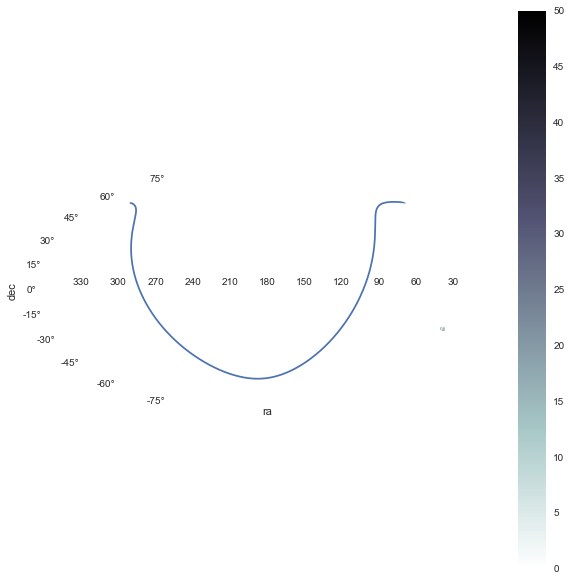

In [7]:
matplotlib.pyplot.figure(figsize=(10, 10))
mclearn.viz.plot_hex_map(ras, decs, labels=True, vmax=50)
matplotlib.pyplot.show()

Little bit small to display like this. How about a heatmap with RA against DEC?

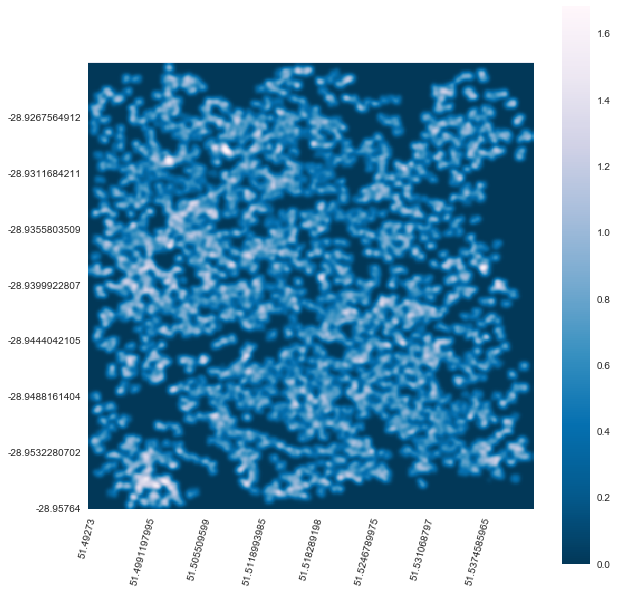

In [32]:
import astropy.convolution
import matplotlib.colors

ras_idx = numpy.linspace(numpy.min(ras), numpy.max(ras), num=400)
dec_idx = numpy.linspace(numpy.min(decs), numpy.max(decs), num=400)
heatmap, _, _ = numpy.histogram2d(ras, decs, bins=[ras_idx, dec_idx])
matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.pcolor(
    astropy.convolution.convolve(heatmap, astropy.convolution.Gaussian2DKernel(stddev=2)),
    cmap='PuBu_r')
matplotlib.pyplot.axis('scaled')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.xticks(range(0, 400, 50), ras_idx, rotation=75)
matplotlib.pyplot.yticks(range(0, 400, 50), dec_idx)
matplotlib.pyplot.show()

## How many galaxies are isolated?

For each galaxy, consider a $0.8'$ neighbourhood centred on the galaxy. How many galaxies have no other galaxies in this neighbourhood, i.e., how many galaxies are isolated?

In [33]:
patch_size = 0.8
isolated_galaxies = []
for galaxy, (ra, dec) in all_galaxies.items():  # This is pretty slow! There are definitely better ways to evaluate this.
    # Find a galaxy less than half a patch size away = 0.2 / 60 degrees away.
    # If we find one, this galaxy is not isolated.
    for other_galaxy, (other_ra, other_dec) in all_galaxies.items():
        if other_galaxy == galaxy:
            continue
        
        if abs(ra - other_ra) <= 0.5*(patch_size) / 60 and abs(dec - other_dec) <= 0.5*(patch_size) / 60:
            break
    else:
        isolated_galaxies.append(galaxy)

In [34]:
print(len(isolated_galaxies))
print('{:.02%}'.format(len(isolated_galaxies)/len(all_galaxies)))

1291
2.30%


So only $2.3\%$ of galaxies are isolated.

## How many crowd AGNs have been classified?

That is, how many consensuses are there? With duplicates, there are $4070$ AGNs. My catalogue code is bugged right now &mdash; the catalogue would contain the answer to this question &mdash; but there's $2423$ radio sources which have been classified to have an associated AGN. This is an upper bound on the number of crowd AGNs.

## How many galaxies with crowd AGNs are isolated?

That is, how many galaxies with an agreed consensus are not near others? Once again, this probably needs the catalogue, but since $2.30\%$ of galaxies are isolated, we could estimate that there are $56$ isolated crowd AGNs.